# Telegram chat analisys

This is a simple script to visualize your telegram chat behaviour such as number of messages per year/month or day, number of media files and most used stickers! I will add new features to this script as soon as possible. Please suggest your ideas to my telegram account: [@conficker](http://t.me/conficker)



## How to use

First of all you need to download your chat history using Telegram Export feature. You can find this feature in Telegram Desktop version 1.4 and later. 

Open chat dialog. At top right of page there is a 3-dot option. Open it and click on `Export chat history`. Currently there is no need to download any media file **Except** sticker option. Set destination folder and click on `Export` button. Wait until the process finishes. **Then copy this notebook on the directory which you selected for export destination.** Now just select **Restart & Run all** button from kernel menu!

In [1]:
import sqlite3
import datetime
import glob
import re
import os
import jdatetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from bs4 import BeautifulSoup
from natsort import natsorted
from PIL import Image

%matplotlib inline

**Note**: This function extracts data from html pages that downloaded by telegram. There is no need to edit this function :)

In [2]:
def extract(message, last_out=False, forward=False):
    global DIALOG_NAME
    text, date, out,reply,id_,fwded = [None]*6

    try:
        out  = message.find('div',{'class':'from_name'}).text.strip() != DIALOG_NAME
    except: # continious PMs
        out = last_out
    
    body = message.find('div',class_='body')
    
    tmp = body.findChildren('div',recursive=False)

    if tmp:        
        last_class = tmp[-1].attrs['class']
    
        if 'text' in last_class:
            text = body.find('div',{'class':'text'}).text.strip()

        elif 'media_wrap' in last_class:

            media_type = body.find('div',class_='media_wrap').findChildren(re.compile('a|div'),recursive=False)[-1].attrs['class']

            if 'sticker_wrap' in media_type:
                text = body.find('img',{'class':'sticker'}).attrs['src']
            elif 'media_photo' in media_type or 'media_video' in media_type or 'media_file' in media_type or 'media_audio_file' in media_type or 'media_voice_message' in media_type or 'media_call' in media_type or 'media_location' in media_type or 'media_contact' in media_type:
                text = "${}$".format(media_type[-1])
            else:
                raise ValueError("%d %s"%(i,str(media_type)))

        elif 'forwarded' in last_class:         
            if not forward:            
                text,*_ =  extract(body,forward=True).values()
                fwded = True
                
        else:
            raise ValueError(last_class)
        
        try:
            reply = body.find('div',{'class':'reply_to'}).find('a').attrs['href']
        except:
            pass
        
        try:
            date = message.find('div',{'class':'date'}).attrs.get('title')    
        except:
            pass

    try:
        id_ = int(''.join(filter(str.isdigit, message.attrs.get('id'))))
    except:
        pass

    if reply:
        reply = int(''.join(filter(str.isdigit, reply)))

    return {'text':text,'date':date,'out':out, 'id':id_,'reply':reply,'forward':fwded}

Here we insert data collected from pages to a sqlite database. If you want keep the order of messages use `natsort` module to sort pages ascendly. 

In [3]:
if os.path.isfile('messages.html'):
    os.rename('messages.html','messages1.html')
    
files = natsorted(glob.glob('messages[0-9]*.html'))
last_out= False

with sqlite3.connect('db.sqlite3') as conn:
    cursor = conn.cursor()    
    try:
        cursor.execute('CREATE TABLE `chats` ( `id` INTEGER, `out` INTEGER, `text` TEXT, `date` TEXT, `reply` INTEGER, `forward` INTEGER );')
    except sqlite3.OperationalError:
        cursor.execute('DELETE FROM `chats`')
    
    for j, file in enumerate(files,1):
        with open(file) as page:
            soup = BeautifulSoup(page,'lxml')
            DIALOG_NAME = soup.find('div',{'class':'page_header'}).text.strip()            
            history = soup.find_all('div',{'class':'history'})[0]
            messages = history.find_all('div',{'class':['message','default','clearfix'],'id':re.compile('message\d+')})                
            for i, message in enumerate(messages):
                ex = extract(message,last_out)
                text,date, out,msg_id,reply,fwd = ex.values()            
                last_out = out
                cursor.execute('INSERT INTO `chats` VALUES(?,?,?,?,?,?)',(msg_id,out,text,date,reply,fwd))
    
    conn.commit()

In [4]:
with sqlite3.connect('db.sqlite3') as conn:
    df = pd.read_sql_query("SELECT date FROM chats", conn)

In [5]:
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M:%S').astype("datetime64")

In [6]:
days,months,years = [],[],[]

# todo: make this one line!
for d in df['date']:
    _date = jdatetime.date.fromgregorian(day=d.day,month=d.month,year=d.year)
    days.append(int(_date.day))
    months.append(int(_date.month))
    years.append(int(_date.year))


In [7]:
df['day'],df['month'],df['year'] = days, months, years
df['time'] = [d.time() for d in df['date']] 
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S')

In [8]:
df.drop('date',inplace=True, axis=1)

In [9]:
counts =  df.groupby(df['year'])['year'].count()
total_chats = int(counts.sum())

print('Total number of messages is %d' %total_chats)

Total number of messages is 171647


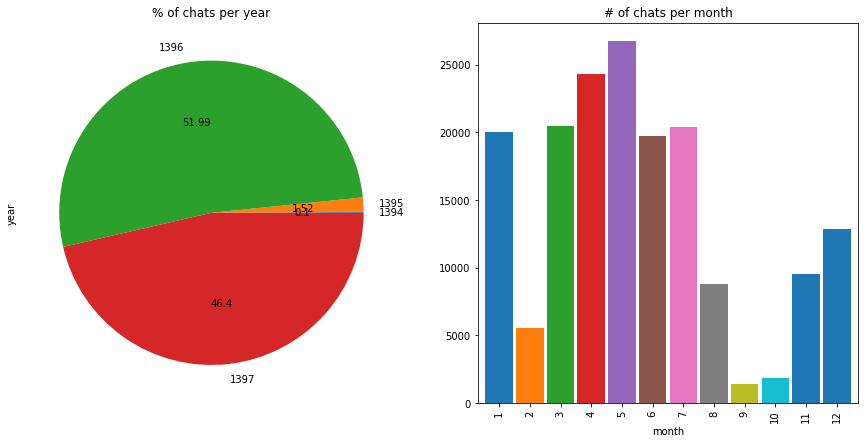

In [10]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7))

counts['year-percentage'] = counts.apply(lambda x:100*x/total_chats)
counts['year-percentage'].plot(kind="pie",legend=False,ax=ax1, autopct=lambda x:round(x,2))
ax1.set_title('% of chats per year')

counts =  df.groupby(df['month']).count()
counts['day'].plot(kind="bar",legend=False,ax=ax2, width=.9)
ax2.set_title('# of chats per month')

print()

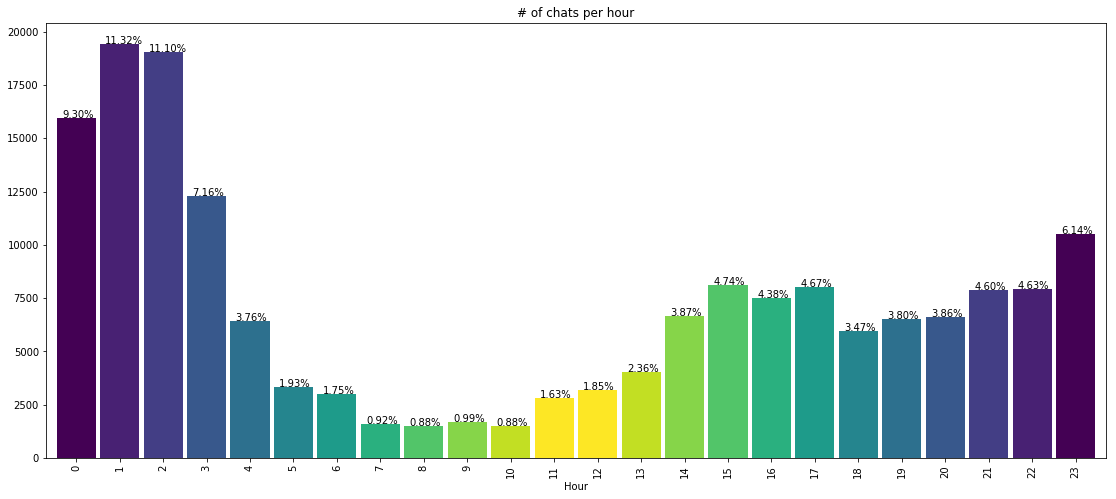

In [11]:
counts =  df.groupby(df['time'].dt.hour)['time'].count()
colors = cm.viridis(np.linspace(0,1,12)).tolist()
colors = colors + colors[::-1]
ax = counts.plot(kind="bar",legend=False,figsize=(19,8),width=.9,color=colors)
x_offset,y_offset = -0.33,5 # change y-offset if it has bad visualization

ax.set_title('# of chats per hour')
ax.set_xlabel('Hour')

for p in ax.patches:
    b = p.get_bbox()
    ax.annotate("{:.2%}".format((b.y1 + b.y0)/total_chats), ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))


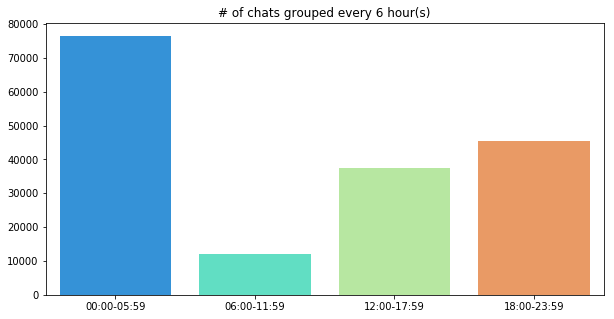

In [12]:
f,ax = plt.subplots(1,1,figsize=(10, 5))
every_n_hours = 6
x = list(range(24//every_n_hours))
y = [0]*24

for i in counts.index:
    y[i] = counts.at[i]

y = [sum(y[i:i+every_n_hours]) for i in range(0,25-every_n_hours,every_n_hours)]
sns.barplot(x,y,palette='rainbow',ax=ax)
ax.set_title('# of chats grouped every %d hour(s)'%every_n_hours)
tmp = ax.set_xticklabels(['%02d:00-%02d:59'%(i,i+every_n_hours-1) for i in range(0,25-every_n_hours,every_n_hours)])

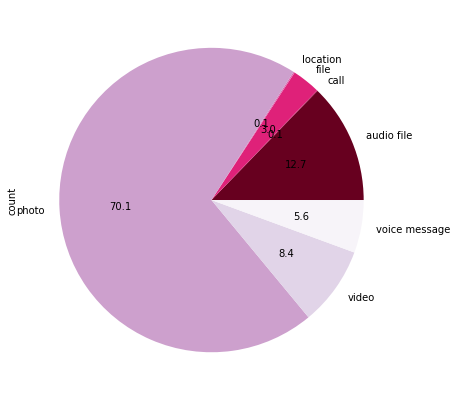

In [13]:
with sqlite3.connect('db.sqlite3') as conn:
    df = pd.read_sql_query("select text as media from chats where text like '$media_%' ", conn)

    df['media'] = df['media'].apply(lambda x:x.strip('$')[6:].replace('_',' '))
    df = df.groupby('media').size().reset_index(name='count')
    df['count'].plot(kind='pie',labels=df['media'],figsize=(7,7),colormap='PuRd_r',autopct=lambda x:round(x,1))

In [14]:
with sqlite3.connect('db.sqlite3') as conn:
    df = pd.read_sql_query("select text as sticker from chats where text like 'stickers/sticker%' ", conn)

In [15]:
df['sticker_name'] = df['sticker'].apply(lambda x:x[:x.index('_')])

df_new = df.groupby('sticker_name').size().reset_index(name='count')

df_new = df_new.sort_values('count', ascending=False)
total_stickers = df_new['count'].sum()

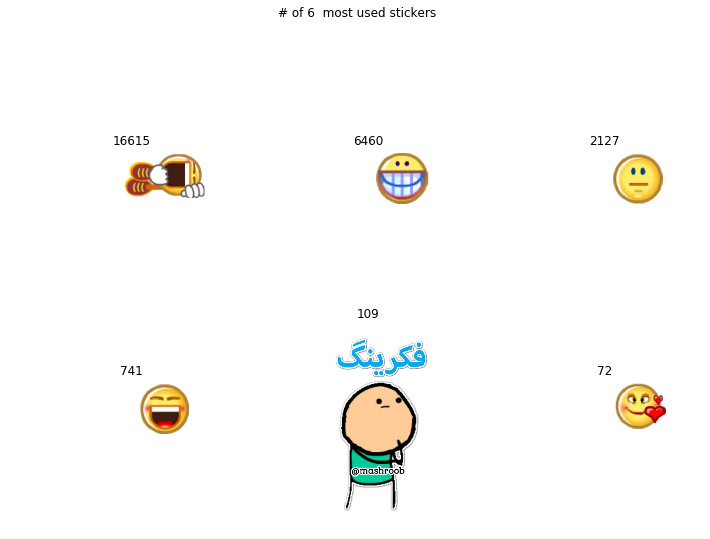

In [16]:
n_max = 6
sticker_counts = list(df_new.iloc[:n_max,1])
imgs = [df[df['sticker_name'] == img]['sticker'].iloc[0] for img in df_new.iloc[:n_max,0]] #

n_row = int(n_max**.5)
n_col = n_max//n_row
fig=plt.figure(figsize=(2*n_max,2*n_max))
n_row +=1
fig.suptitle('# of %d  most used stickers'%n_max)
for i,img in enumerate(imgs,1):    
    ax = Image.open(img)
#     ax = ax.crop(ax.getbbox())
    axs = fig.add_subplot(n_row,n_col, i)
    axs.axis('off')
#     axs.set_xlim(300)    
    axs.set_title(str(sticker_counts[i-1]))
    axs.imshow(np.asarray(ax))

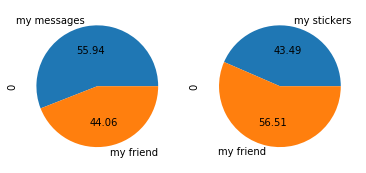

In [17]:
f,(ax1,ax2) = plt.subplots(1,2)

with sqlite3.connect('db.sqlite3') as conn:
    my_messages = int(conn.execute("select count(out) as count from chats where out = '1'").fetchone()[0])
    
    df = pd.DataFrame([my_messages,total_chats-my_messages], index=['my messages','my friend'])
    
    df.plot(kind='pie',subplots=True,autopct=lambda x:round(x,2),legend=False,ax=ax1)

with sqlite3.connect('db.sqlite3') as conn:
    my_stickers = int(conn.execute("select count(out) as count from chats where out = '1' and text like 'stickers/sticker%'").fetchone()[0])
    
    df = pd.DataFrame([my_stickers,total_stickers-my_stickers], index=['my stickers','my friend'])
    
    df.plot(kind='pie',subplots=True,autopct=lambda x:round(x,2),legend=False,ax=ax2)